# 03_fredf_baseline

Прототип реализации FreDF и сравнение с базовыми моделями.

# Применение моделей на исходных данных

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 300

from ts_toolkit.io import clean_timeseries
from ts_toolkit.calendar import add_hour_sin_cos
from ts_toolkit.viz import plot_history_forecast
from ts_toolkit.split import three_way_split
from src.models.catboost_delay_model import DelayForecastModel
from ts_toolkit.metrics import daily_mae
from ts_toolkit.metrics import global_metrics

In [3]:
from src.data_loader import fetch_frame
# df = fetch_frame()
df = fetch_frame(
    use_cache=True,
    cache_filename="only_common_delayp90.parquet"
)
print(df.head())

print(df.info())

print(df.describe())

print(df.isnull().sum())


                     common_delay_p90
ts                                   
2025-04-27 18:00:30       2394.210526
2025-04-27 18:00:45       2398.424069
2025-04-27 18:01:00       2396.124524
2025-04-27 18:01:15       2417.008604
2025-04-27 18:01:30       2420.737327
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90643 entries, 2025-04-27 18:00:30 to 2025-05-13 11:41:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   common_delay_p90  90641 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB
None
       common_delay_p90
count      90641.000000
mean        1802.349510
std          901.617551
min          235.000000
25%          922.395833
50%         2094.852941
75%         2382.755633
max         8500.000000
common_delay_p90    2
dtype: int64


In [4]:
df.info()

df.describe()

df.isnull().sum()

df.head()

df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90643 entries, 2025-04-27 18:00:30 to 2025-05-13 11:41:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   common_delay_p90  90641 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


,common_delay_p90
ts,
2025-05-13 11:40:00,3738.866397
2025-05-13 11:40:15,3325.806452
2025-05-13 11:40:30,2479.835391
2025-05-13 11:40:45,2452.444134
2025-05-13 11:41:00,2498.843188


In [5]:
df = clean_timeseries(df, 'common_delay_p90')   # вместо блока 0‑3
df = add_hour_sin_cos(df)
feature_cols = ['hour_sin', 'hour_cos']

In [6]:
feature_cols

['hour_sin', 'hour_cos']

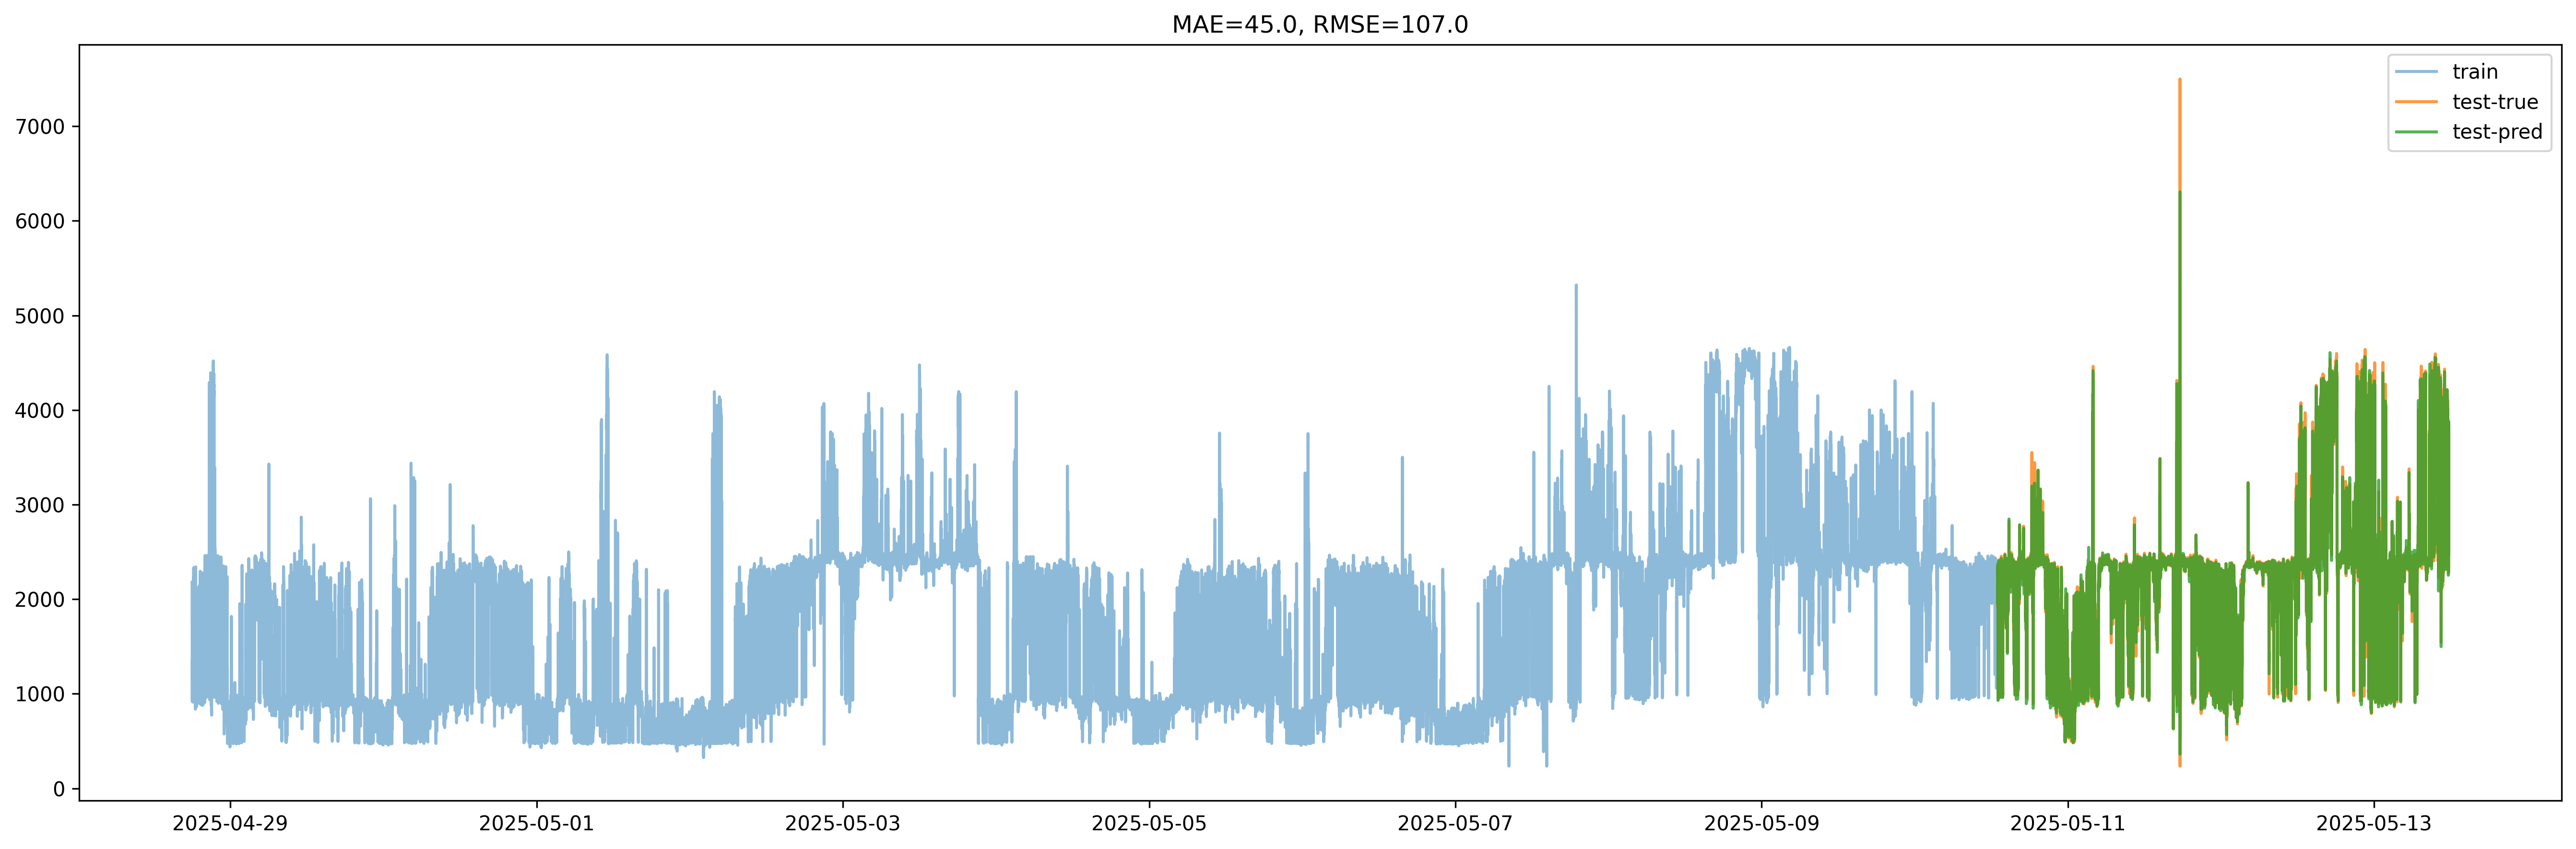

In [7]:
# инициализируем — можно менять lags/roll_windows/test_size
model = DelayForecastModel(
    horizon       = 5760,   # сутки = 24*60*60 / 15 = 5760 точек
    test_size     = 0.2,    # 80 % train, 20 % hold-out
    lags          = [1, 2, 4, 96, 192, 5760],
    # roll_windows  = [96, 384, 5760]          # 24 мин, 1 ч, 1 сут
    roll_windows  = [4,96,192,1920,2880,4320,5760,8640]
)


# fit + автоматически нарисует график «train / test-true / test-pred»
train_df, test_df = model.fit(
    df,
    target_col   = 'common_delay_p90',
    feature_cols = feature_cols,      # если есть другие метрики — впишите их названия здесь
    plot         = True
)

In [8]:
print(len(train_df), len(test_df))

67906 16977


/var/folders/hz/g0q481y17153sdyxw9_71p380000gn/T/ipykernel_23112/3164536513.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  future_index   = pd.date_range(


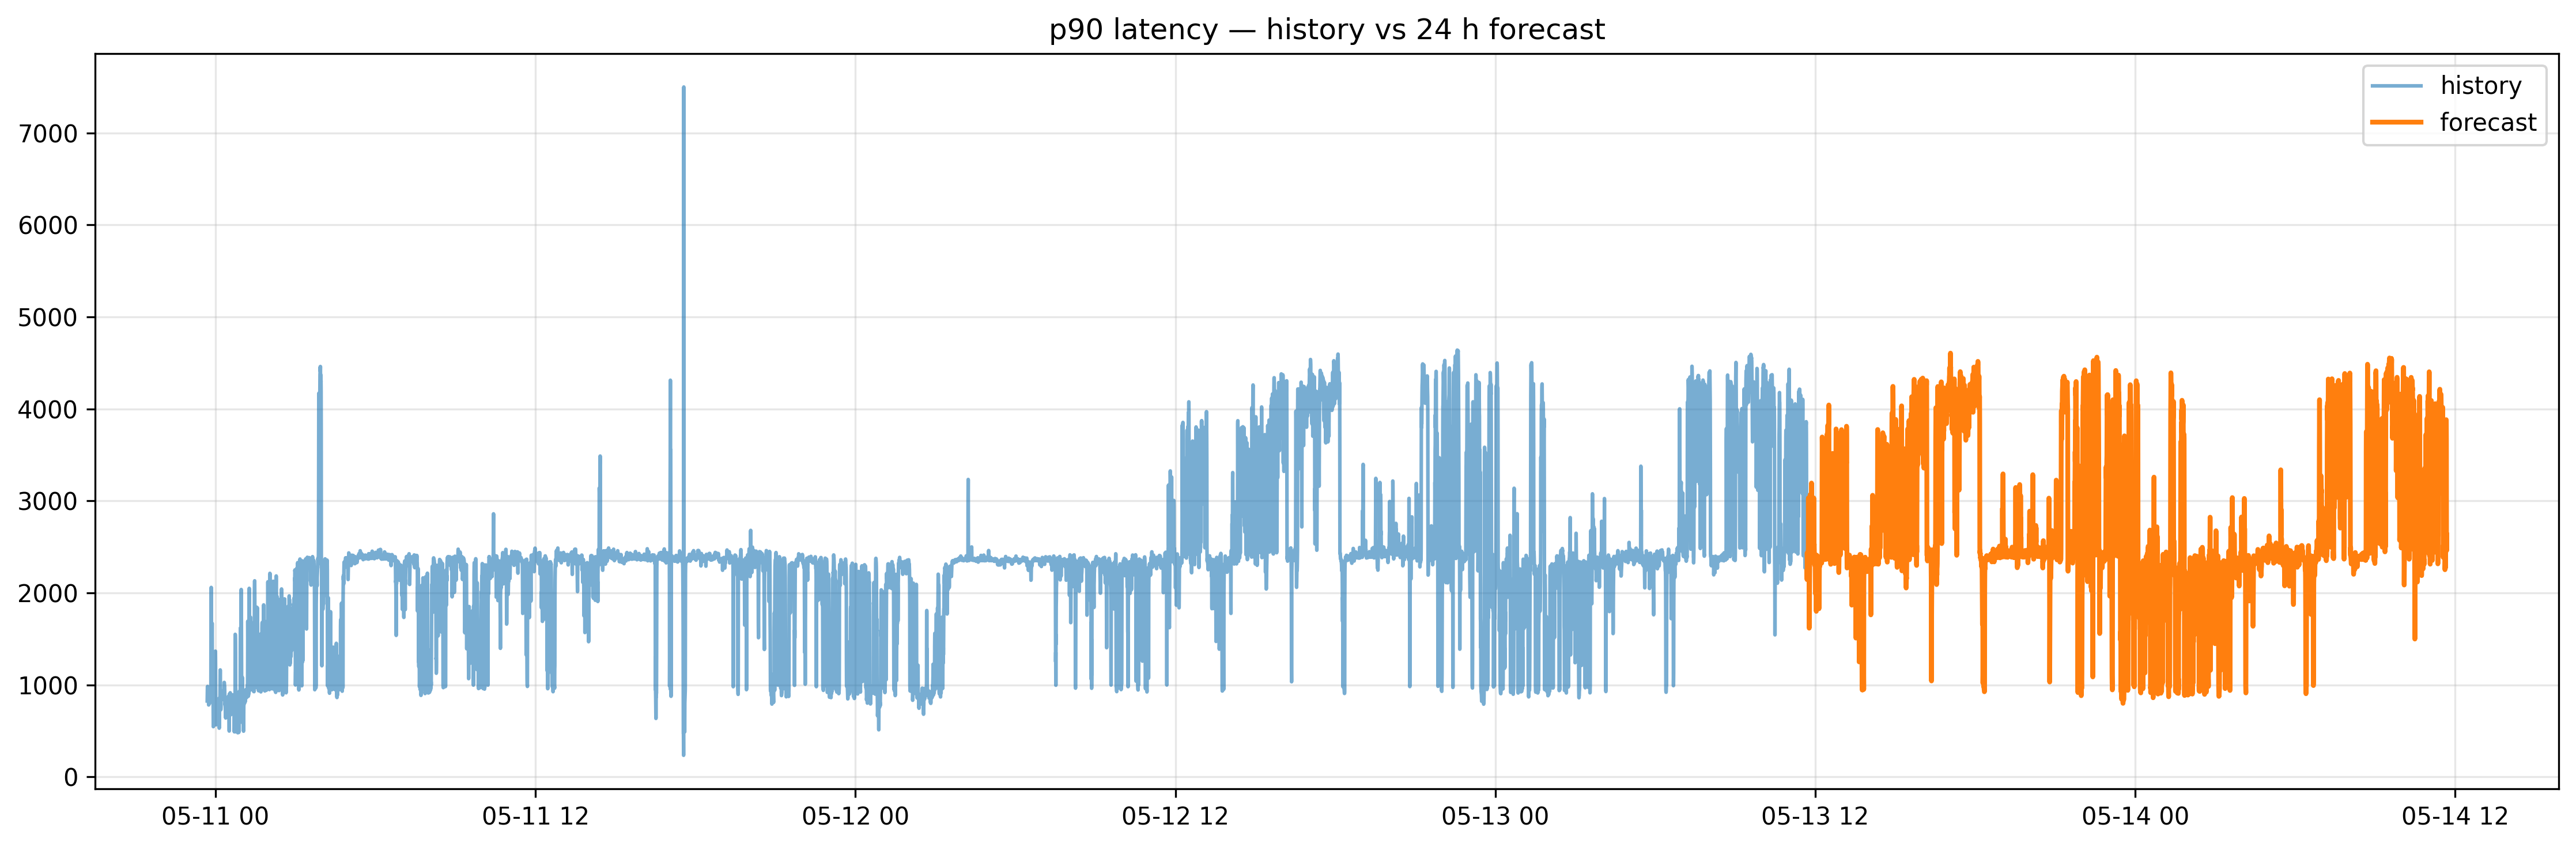

In [9]:
# берём последние (max(lags, roll_windows) + horizon) точек
history_needed = max(model.lags + model.roll_windows) + model.horizon
df_last = df.tail(history_needed)

# готовим фичи и предсказываем
df_future = model.prepare_future(df_last, 'common_delay_p90')

y_hat_next_day = model.predict(df_future)[-model.horizon:]
future_index   = pd.date_range(
    start=df.index[-1] + pd.Timedelta(seconds=15),
    periods=model.horizon,
    freq='15S'
)

from ts_toolkit.viz import plot_history_forecast

# ----- визуализация прогноза -----
history_series = df_last['common_delay_p90'].iloc[-3*5760:]
forecast_series = pd.Series(y_hat_next_day, index=future_index)

plot_history_forecast(
    history=history_series,
    forecast=forecast_series,
    title='p90 latency — history vs 24 h forecast'
)


## 2. Код-шаблоны для подробного анализа



*** Hold-out metrics ***
           value
MAE    45.030470
RMSE  106.974189
MAPE    2.164323

MAE by day:
        index        MAE
0  2025-05-10  29.305263
1  2025-05-11  36.299714
2  2025-05-12  49.677639
3  2025-05-13  68.283488


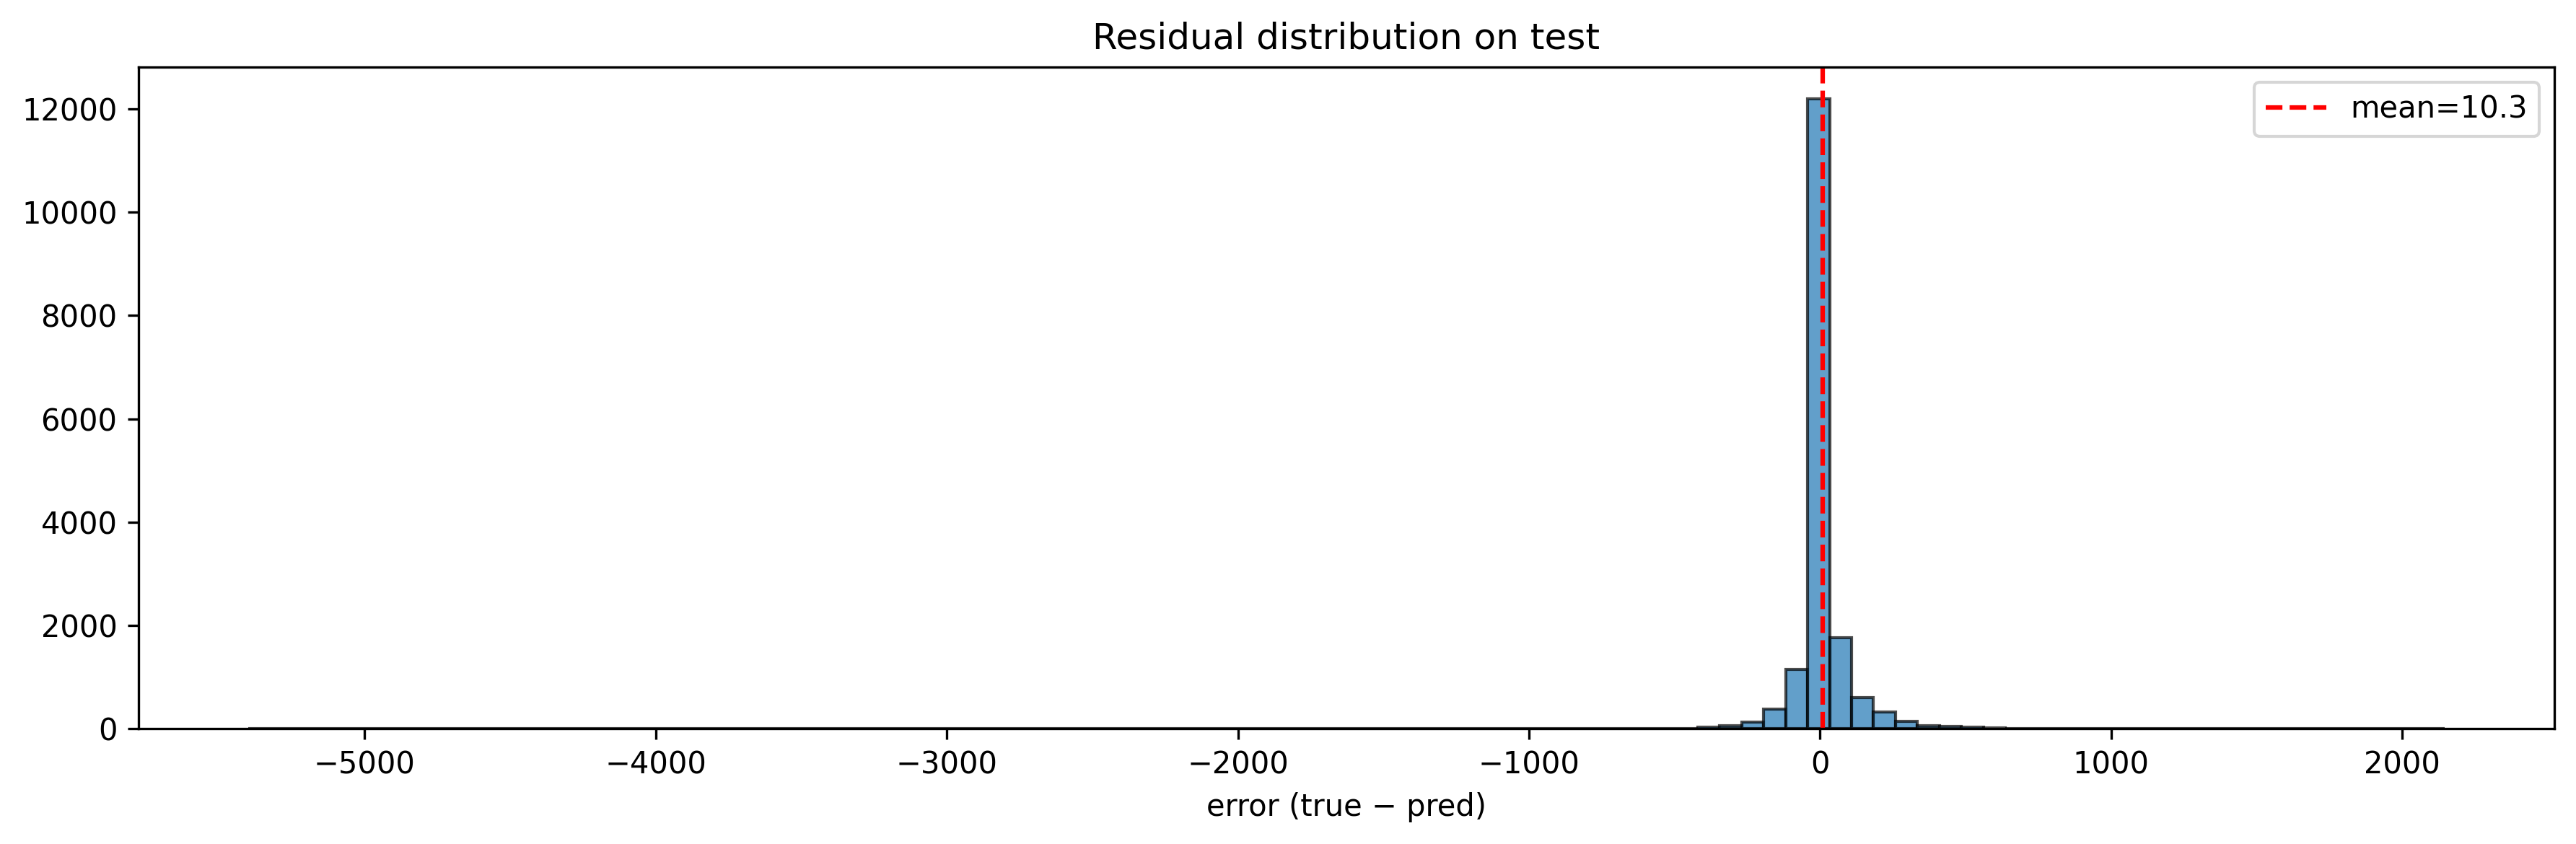

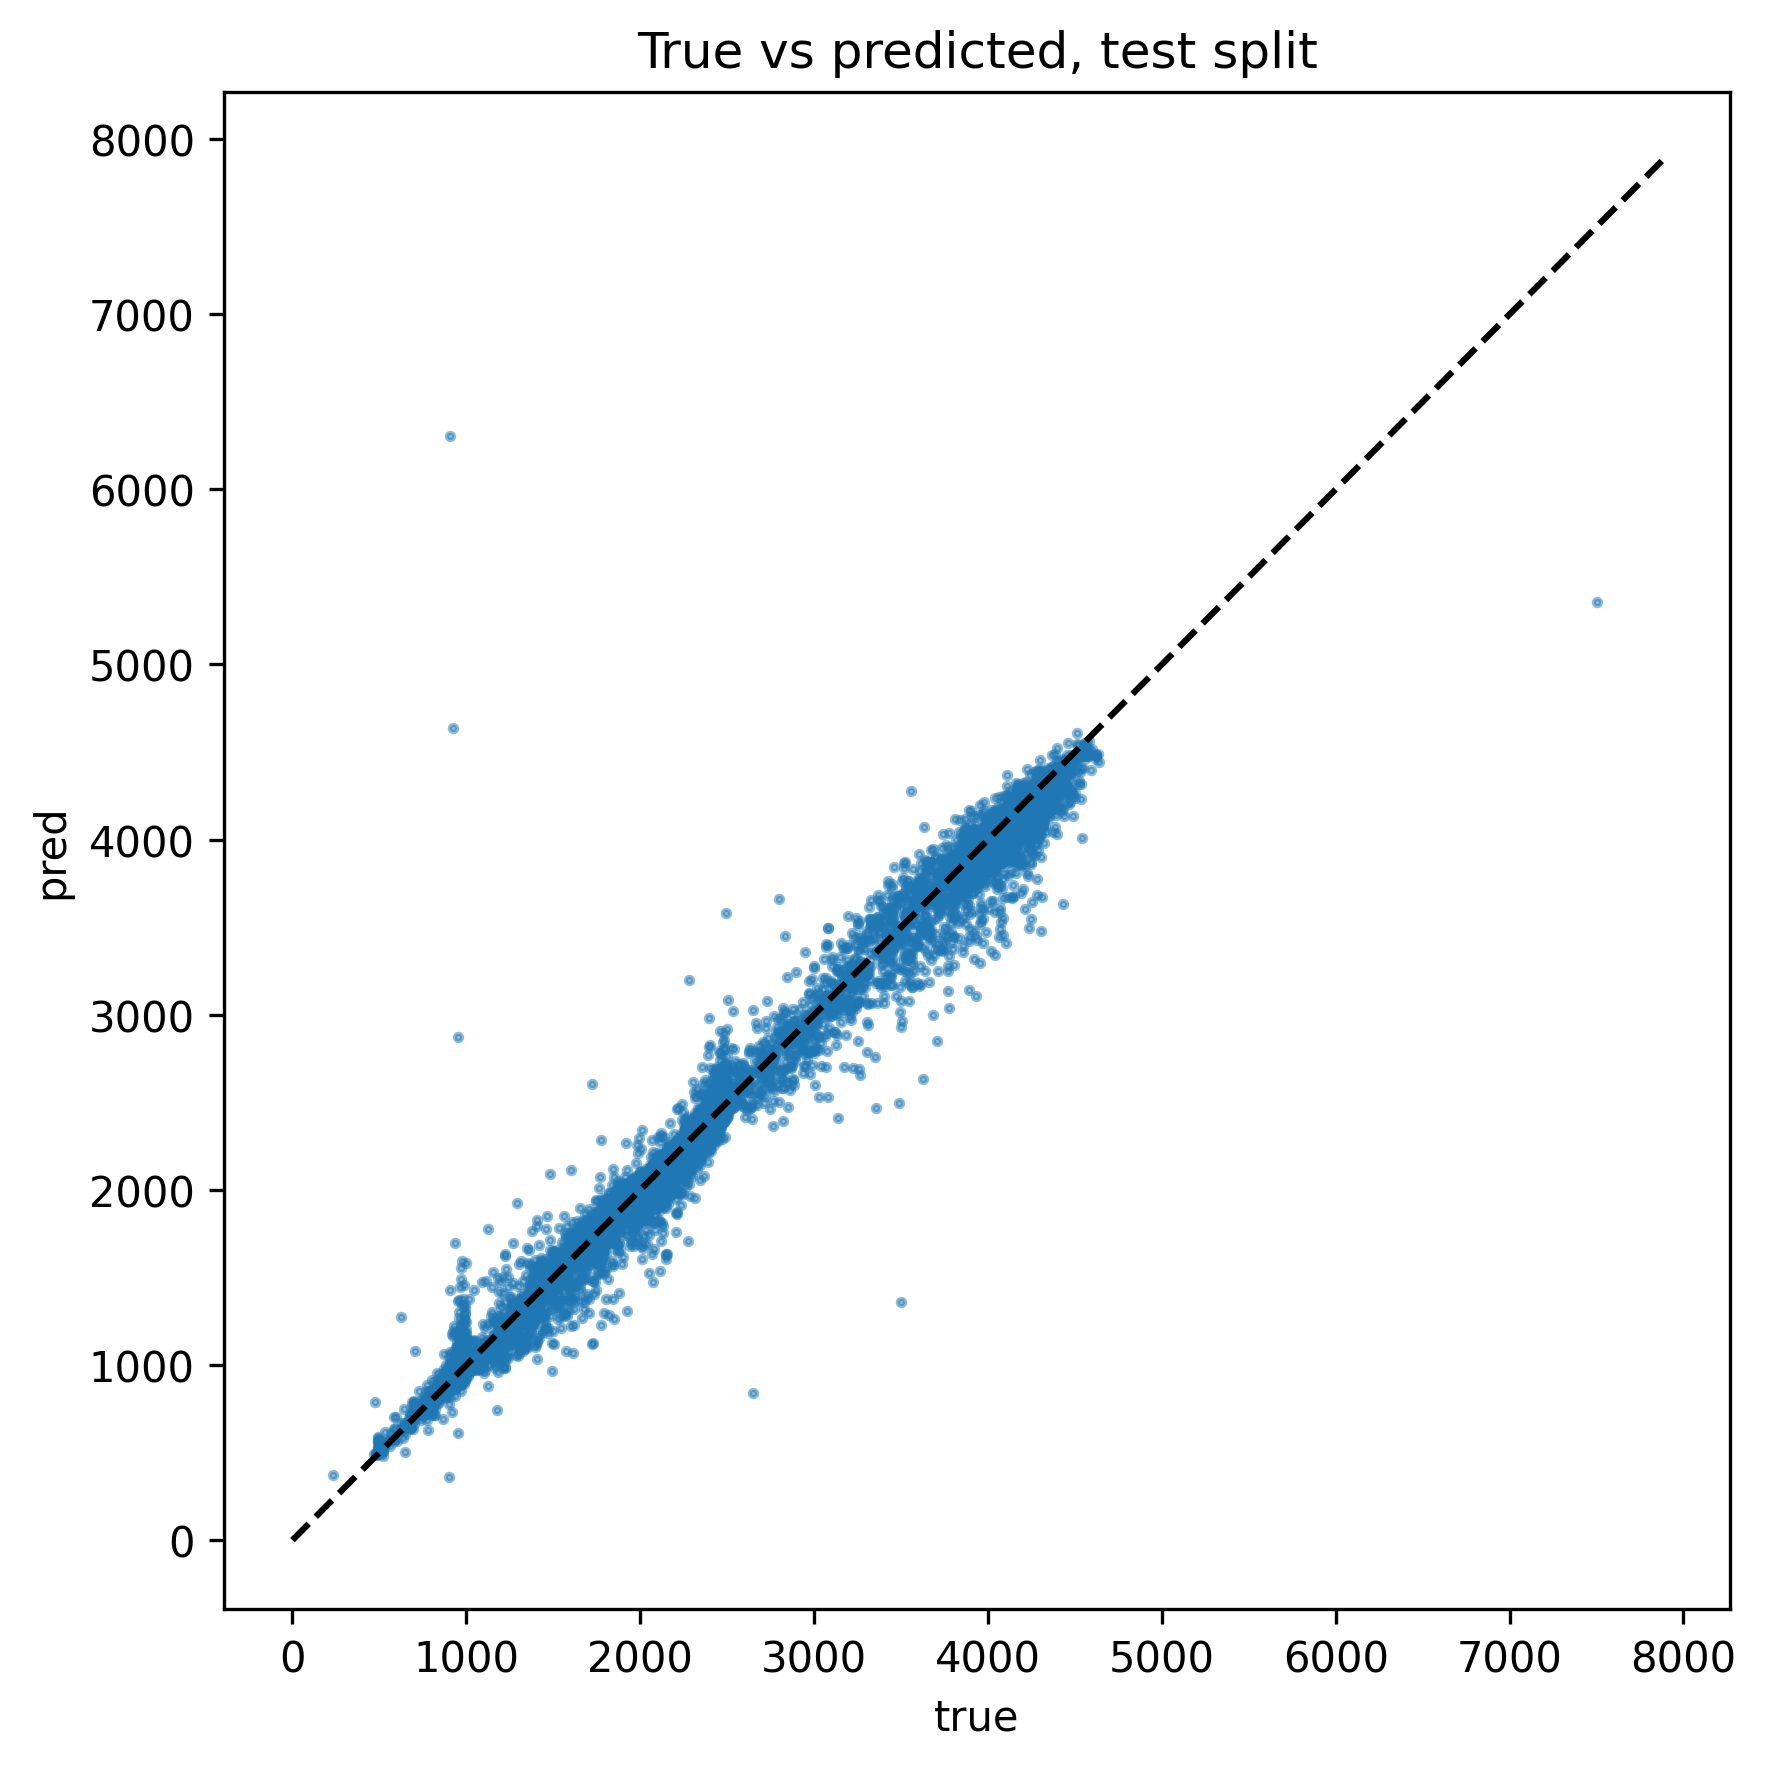

In [10]:
# ---------------------------------------------------
# 2.1  получить true & pred на тесте
# ---------------------------------------------------
#  полный список признаков, который модель видела
feat_cols = model.model.feature_names_          # ровно в том порядке!
test_feat  = test_df[feat_cols]                 # никаких пропусков
assert list(test_feat.columns) == list(model.model.feature_names_)

# 1. истинные значения и прогноз
test_true  = test_df['common_delay_p90']
test_pred  = pd.Series(
    model.model.predict(test_feat),
    index=test_true.index,
    name='pred'
)

# 2. остатки
resid = test_true - test_pred


# ---------------------------------------------------
# 2.2  сводные метрики
# ---------------------------------------------------
metrics = global_metrics(test_true, test_pred)
metrics_df = pd.DataFrame([metrics]).T.rename(columns={0: "value"})
print("\n*** Hold-out metrics ***")
print(metrics_df)

# ---------------------------------------------------
# 2.3  метрики по суткам
# ---------------------------------------------------
daily_mae_result = daily_mae(test_true, test_pred)
print("\nMAE by day:")
print(daily_mae_result.tail())

# ---------------------------------------------------
# 2.4  распределение ошибок
# ---------------------------------------------------
plt.figure(figsize=(12,4))
plt.hist(resid, bins=100, alpha=.7, edgecolor='black')
plt.axvline(resid.mean(), color='r', linestyle='--', label=f"mean={resid.mean():.1f}")
plt.title("Residual distribution on test")
plt.xlabel("error (true − pred)")
plt.legend(); plt.tight_layout(); plt.show()

# ---------------------------------------------------
# 2.5  true vs pred scatter
# ---------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(test_true, test_pred, s=3, alpha=0.5)
lim = [0, max(test_true.max(), test_pred.max())*1.05]
plt.plot(lim, lim, 'k--')
plt.xlabel("true"); plt.ylabel("pred")
plt.title("True vs predicted, test split")
plt.tight_layout(); plt.show()


## 3. Feature Importance (какие лаги реально работают)

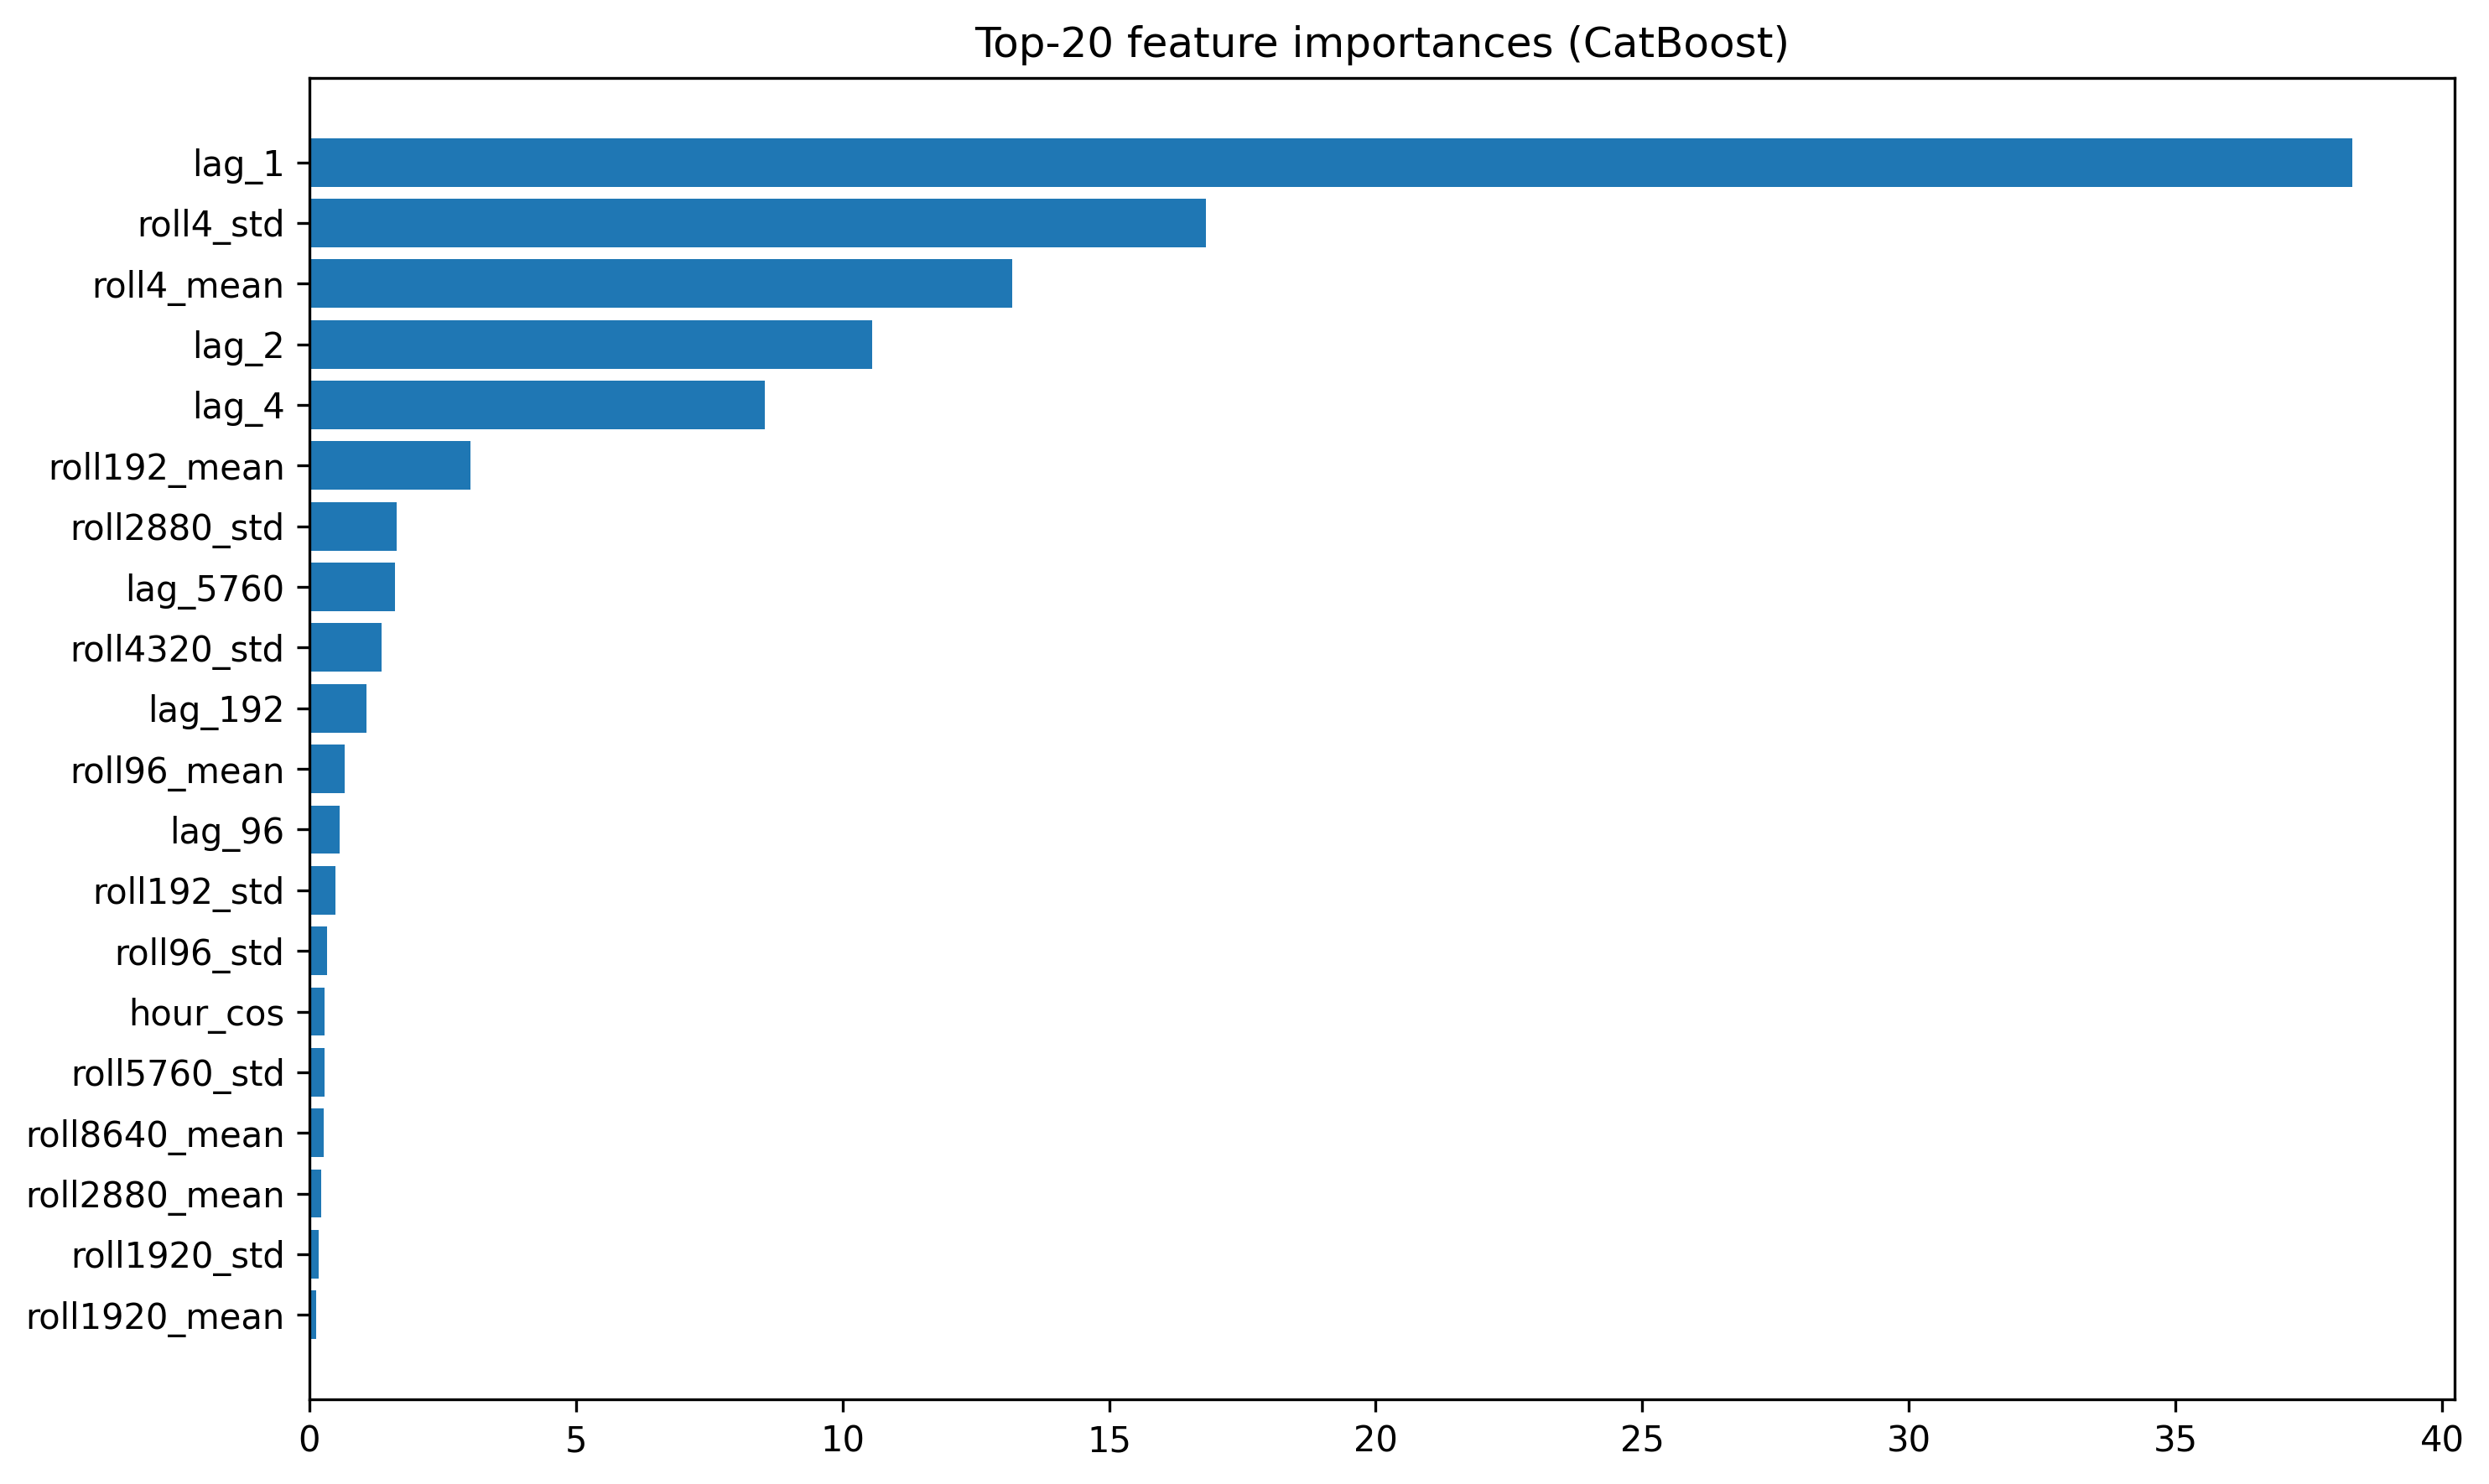

In [11]:
feat_names = model.model.feature_names_        # ← то, что CatBoost запомнил
importances = model.model.get_feature_importance(type='FeatureImportance')

# в один датафрейм
imp_df = (pd.DataFrame({"feature": feat_names,
                        "importance": importances})
            .sort_values(by="importance", ascending=False)
            .reset_index(drop=True))

# ---------------------------------------------------
#  топ-20 на графике
# ---------------------------------------------------
plt.figure(figsize=(10,6))
plt.barh(imp_df.feature.head(20)[::-1],
         imp_df.importance.head(20)[::-1])
plt.title("Top-20 feature importances (CatBoost)")
plt.tight_layout(); plt.show()


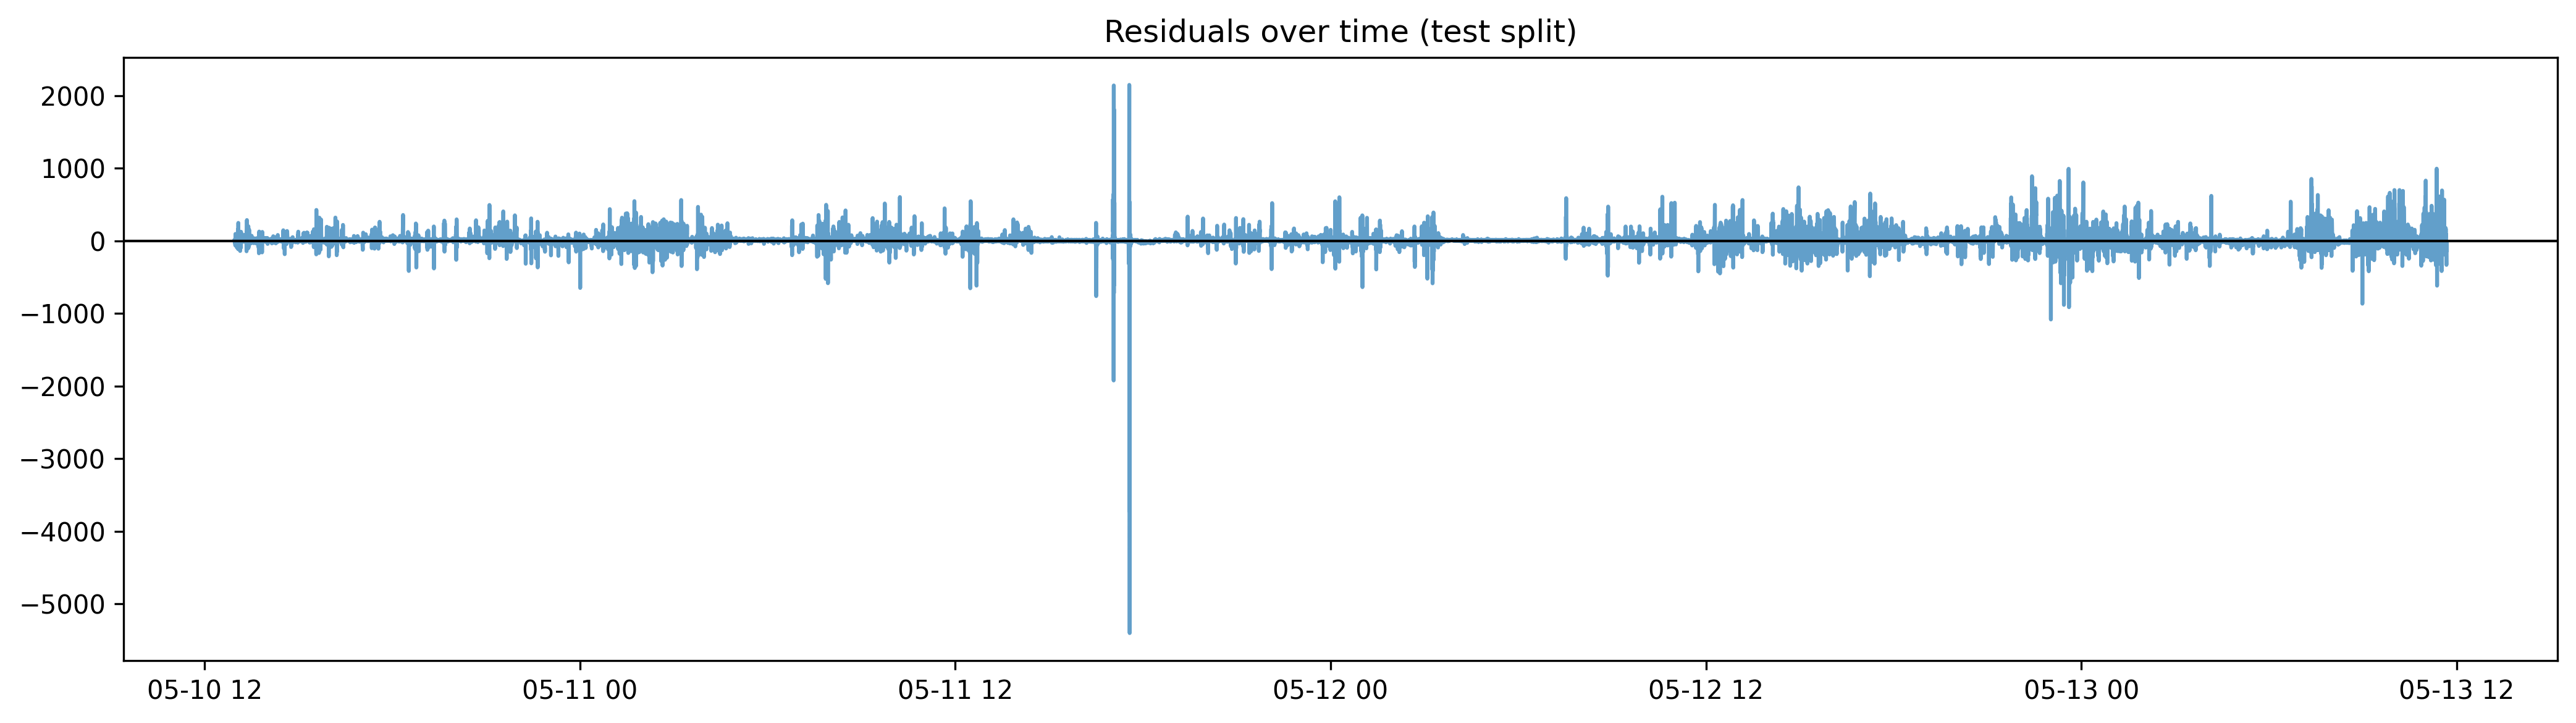

In [12]:
plt.figure(figsize=(14,4))
plt.plot(resid.index, resid, alpha=0.7)
plt.title("Residuals over time (test split)")
plt.axhline(0, color='k', lw=1)
plt.tight_layout(); plt.show()


# Проверка на реальных данных

Blind 24-h test • MAE=24.4  RMSE=59.8  MAPE=1.55%  on 2890 valid points


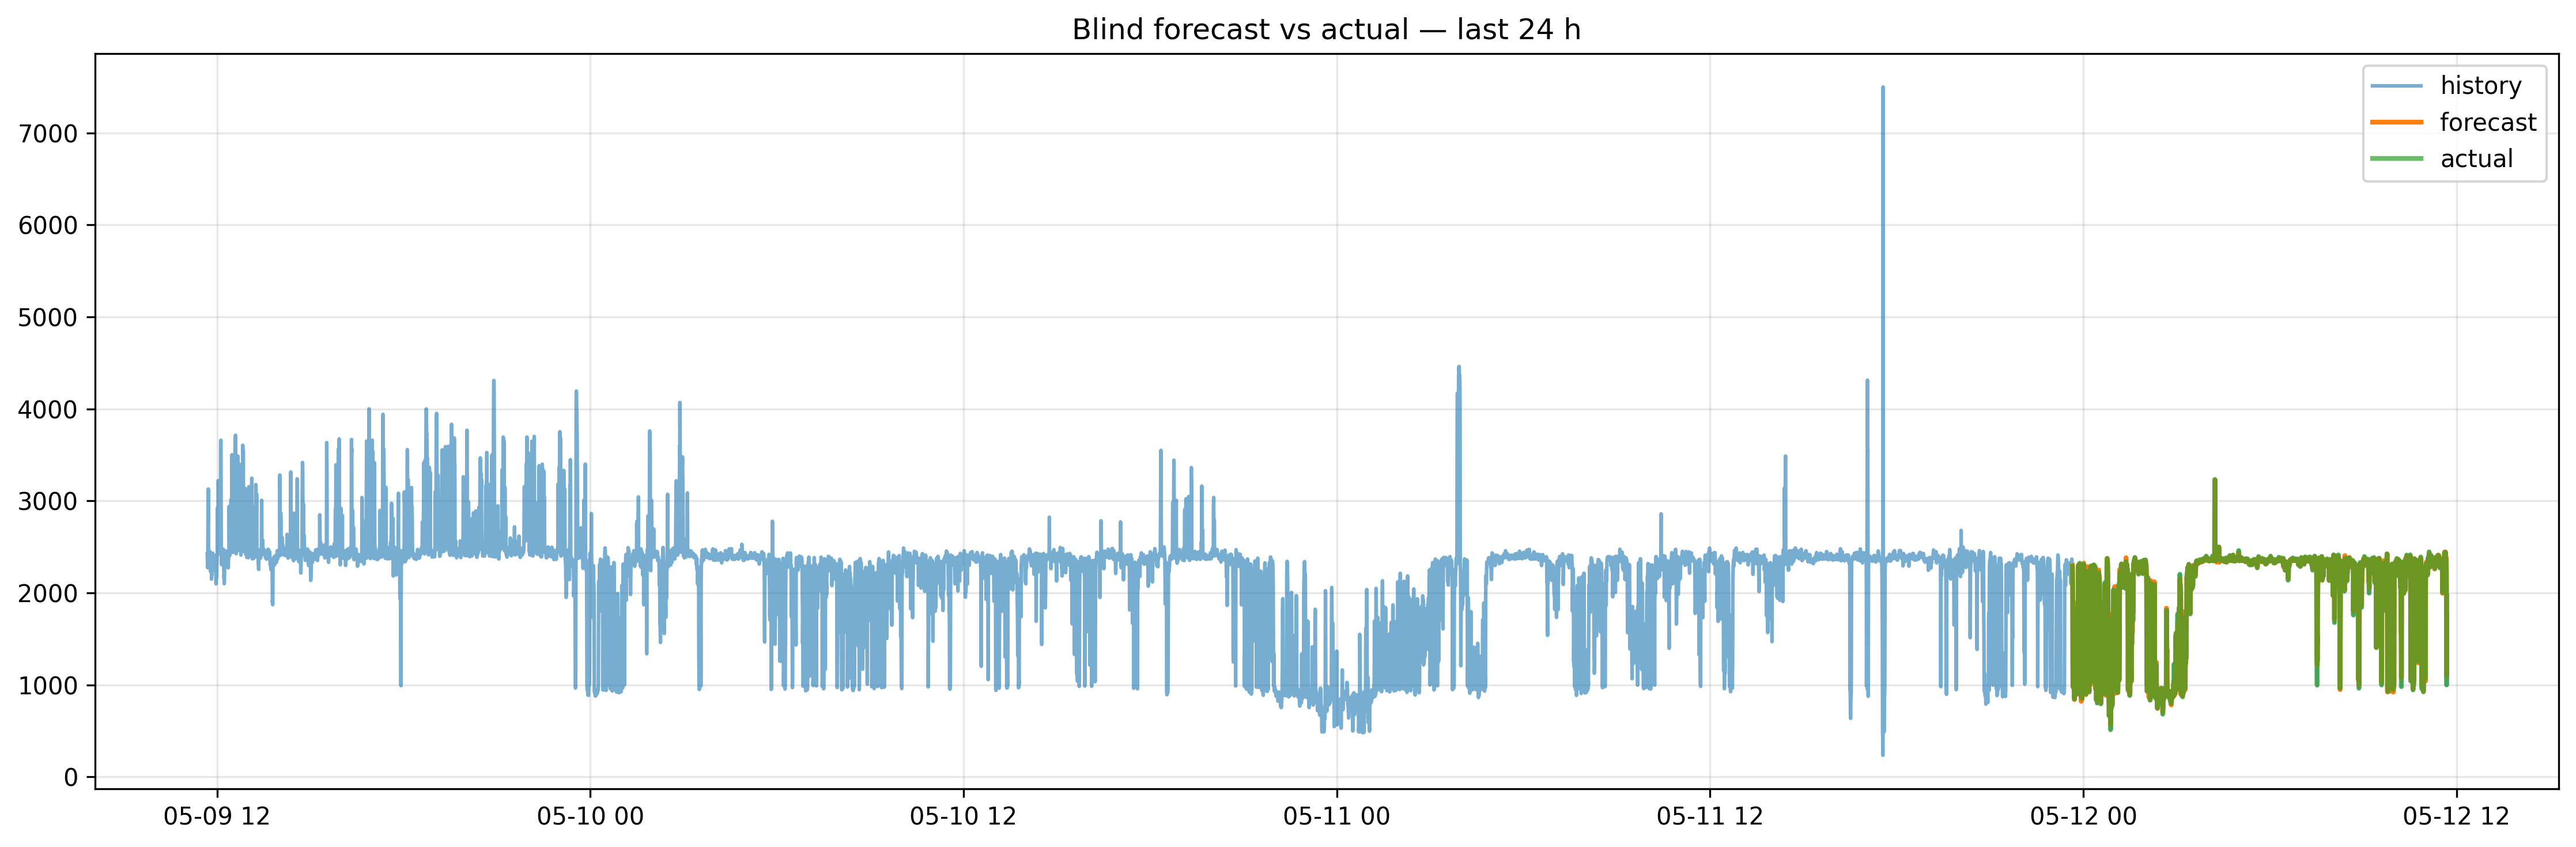

In [13]:
# ─────────────────────────────────────────────────────────────
# 1.  выбираем точку отсечки (24 h до конца ряда)
# ─────────────────────────────────────────────────────────────
step       = pd.Timedelta(seconds=15)
H          = model.horizon                   # 5760
cut_time   = df.index[-H-1]                  # last seen by model

hist_need  = max(model.lags + model.roll_windows) + 10
df_hist    = df.loc[:cut_time].tail(hist_need)

# ─────────────────────────────────────────────────────────────
# 2.  генерируем признаки и прогноз
# ─────────────────────────────────────────────────────────────
df_future  = model.prepare_future(df_hist, 'common_delay_p90')
y_pred     = model.model.predict(df_future)

pred_idx   = df_future.index            # ровно столько, сколько точек в y_pred
pred_ser   = pd.Series(y_pred, index=pred_idx, name='pred')

# ─────────────────────────────────────────────────────────────
# 3.  реальные значения (align по pred_idx)
# ─────────────────────────────────────────────────────────────
y_true = df['common_delay_p90'].loc[pred_idx]   # факты под теми же метками

# ─────────────────────────────────────────────────────────────
# 4.  метрики
# ─────────────────────────────────────────────────────────────
metrics = global_metrics(y_true, pred_ser)
print(f"Blind 24-h test • MAE={metrics['MAE']:.1f}  RMSE={metrics['RMSE']:.1f}  MAPE={metrics['MAPE']:.2f}%  "
      f"on {len(y_true)} valid points")

# ─────────────────────────────────────────────────────────────
# 5.  график: 3 сут истории + пред / факт
# ─────────────────────────────────────────────────────────────

hist_start = cut_time - pd.Timedelta(hours=72)
plot_history_forecast(
    history  = df.loc[hist_start:cut_time, 'common_delay_p90'],
    forecast = pred_ser,
    actual   = y_true,
    title    = 'Blind forecast vs actual — last 24 h'
)


In [14]:
print("train_END :", train_df.index[-1])
print("cut_time  :", cut_time)
print("cut_time > train_END ?", cut_time > train_df.index[-1])


train_END : 2025-05-10 12:56:45
cut_time  : 2025-05-12 11:41:00
cut_time > train_END ? True


# Максимально честный тест

In [15]:
df_train, df_val, df_hold = three_way_split(df, train_ratio=0.7, val_ratio=0.2)

# ── fit на train, early-stop на val ───────────────────────────
model = DelayForecastModel(
    horizon       = 5760,   # сутки = 24*60*60 / 15 = 5760 точек
    test_size     = 0.2,    # 80 % train, 20 % hold-out
    lags          = [1, 2, 4, 96, 192, 5760],
    # roll_windows  = [96, 384, 5760]          # 24 мин, 1 ч, 1 сут
    roll_windows  = [4,96,192,1920,2880,4320,5760,8640]
)
train_df, _ = model.fit(
    df_train, 'common_delay_p90',
    feature_cols=['hour_sin','hour_cos'],
    plot=False
)

# ── прогноз на hold-out (слепой) ──────────────────────────────
history_need = max(model.lags + model.roll_windows) + 10
df_hist = pd.concat([df_val, df_hold]).tail(history_need)   # контекст

df_future = model.prepare_future(df_hist, 'common_delay_p90')
y_pred    = model.model.predict(df_future)
pred_idx  = df_future.index

y_true    = df_hold['common_delay_p90'].reindex(pred_idx).dropna()
y_pred    = pd.Series(y_pred, index=pred_idx).loc[y_true.index]

# print("MAE =", mean_absolute_error(y_true, y_pred))


Blind 24-h test • MAE=111.2  RMSE=190.0  MAPE=3.72%  on 2890 valid points


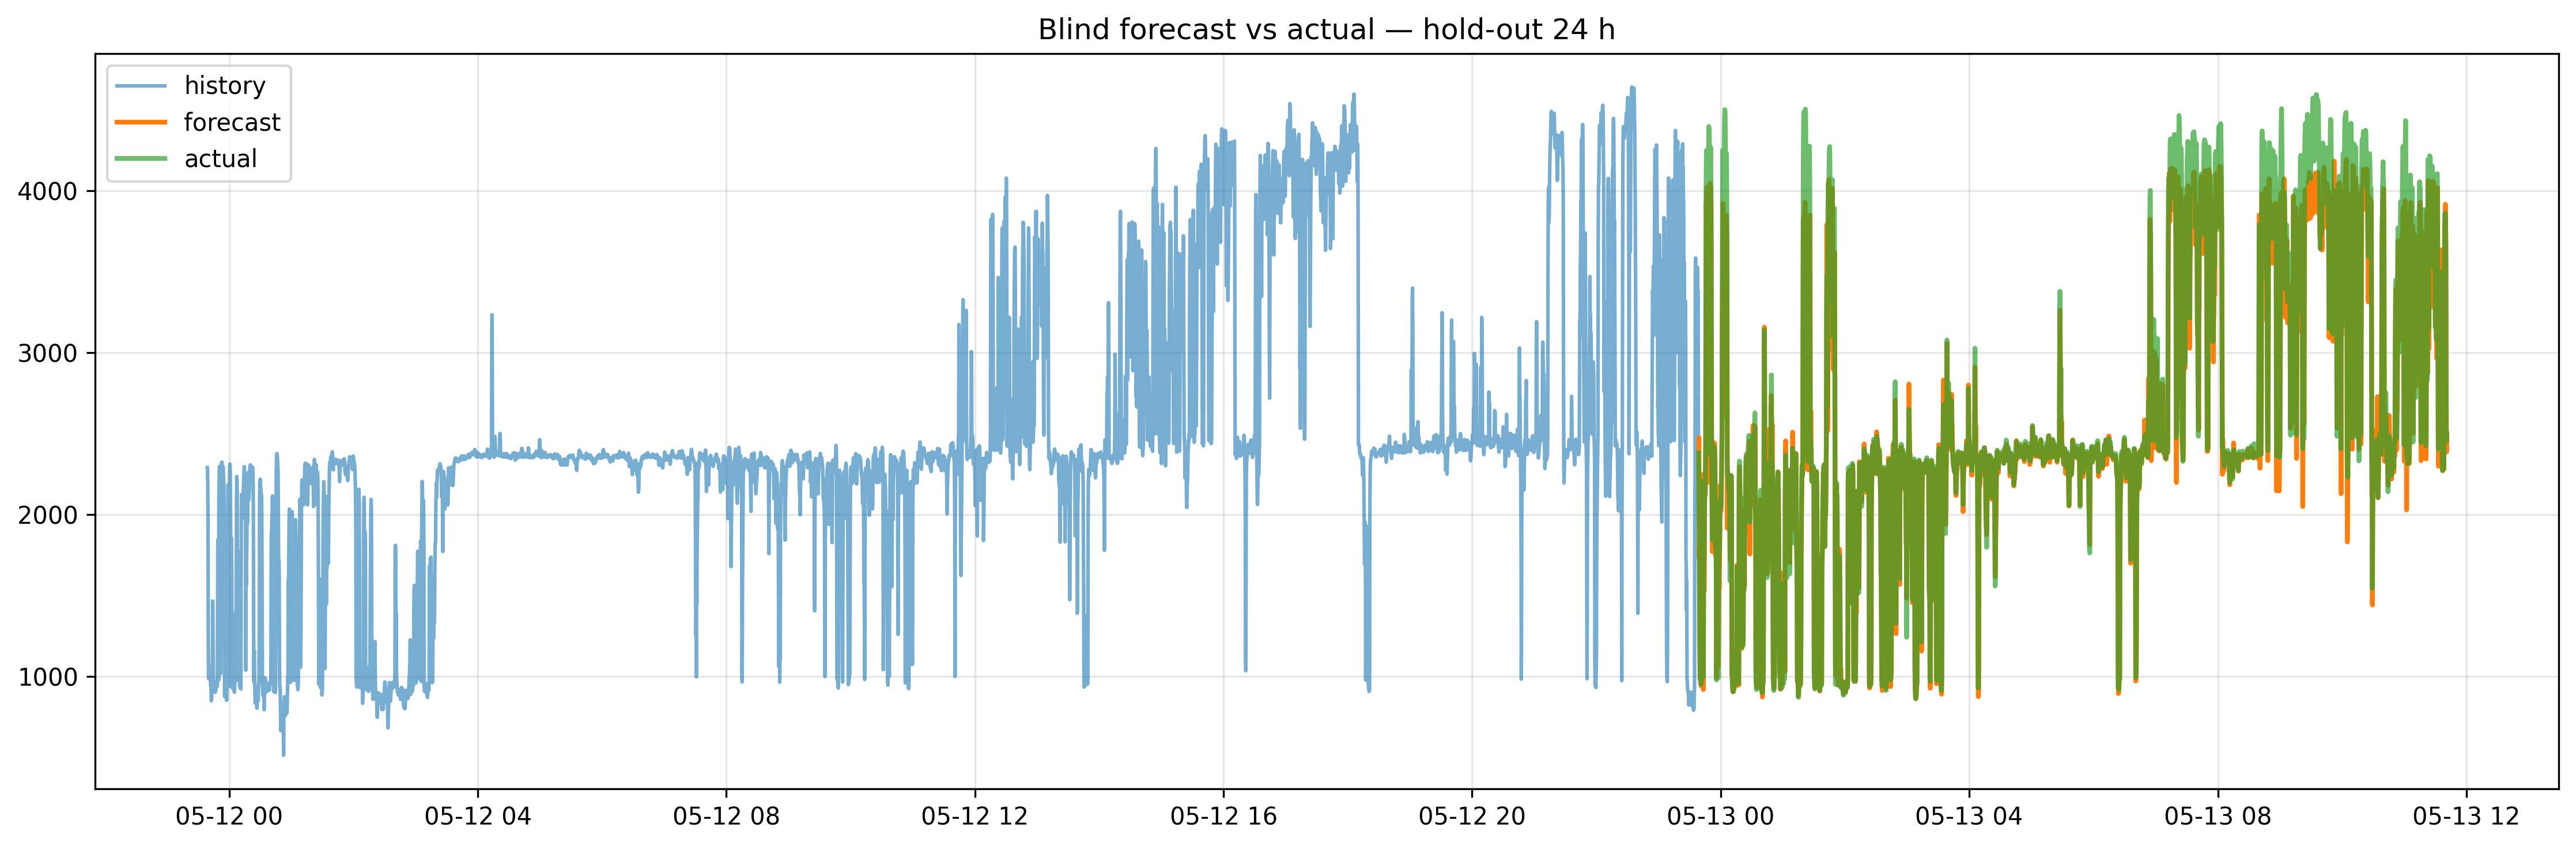

In [16]:
# pred_idx и y_pred уже получены в предыдущем шаге
y_true = df['common_delay_p90'].loc[pred_idx]

metrics = global_metrics(y_true, y_pred)
print(f"Blind 24-h test • MAE={metrics['MAE']:.1f}  RMSE={metrics['RMSE']:.1f}  MAPE={metrics['MAPE']:.2f}%  "
      f"on {len(y_true)} valid points")

# ── график: история 3 сут + прогноз vs факт ──
hist_start = pred_idx[0] - pd.Timedelta(hours=24)
plot_history_forecast(
    history  = df.loc[hist_start:pred_idx[0], 'common_delay_p90'],
    forecast = pd.Series(y_pred, index=pred_idx),
    actual   = y_true,
    title    = 'Blind forecast vs actual — hold-out 24 h'
)


In [17]:
from ts_toolkit.metrics import daily_mae

daily_mae_df = daily_mae(y_true, y_pred)
print(daily_mae_df)

        index         MAE
0  2025-05-12  133.800334
1  2025-05-13  110.480566
